In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime
import time

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Learning.loss_terms as loss_terms
import Plotting.plotters_h1h2 as plotters_h1h2
import Learning.training_data as training_data


/home/kian/anaconda3/envs/thesis2/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

cpu
{'l1': 2, 'l2': 2, 'm': 3, 'g': 9.81, 'xa': 5, 'ya': 1}


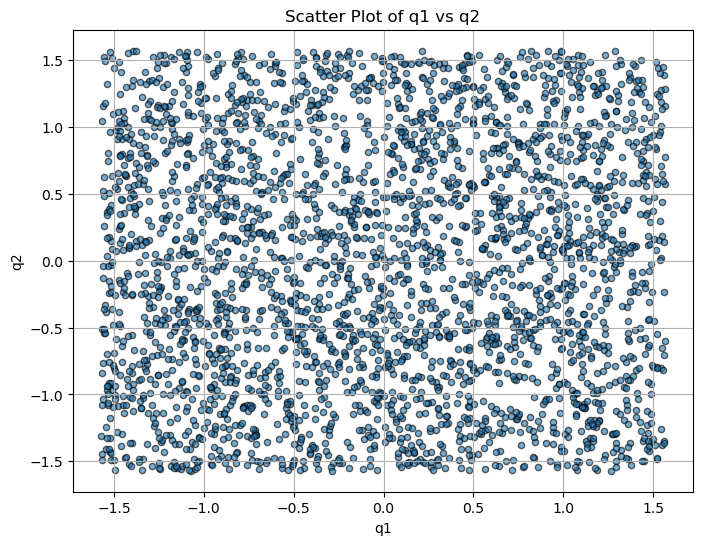

In [3]:
import numpy as np


# Retrieve training points
points = training_data.points.to(device)

# Plot q1 vs q2
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()

In [4]:
# Compute mass- and input matrix of all training points to reduce load in training

data_pairs = []
for point in points:
    Mq_point, _, _ = dynamics.dynamical_matrices(rp, point, point)
    Aq_point = dynamics.input_matrix(rp, point)
    data_pairs.append((point, Mq_point, Aq_point))

points_tensor = torch.stack([pair[0] for pair in data_pairs])           # Tensor of all points
mass_matrices_tensor = torch.stack([pair[1] for pair in data_pairs])   # Tensor of all mass matrices
input_matrices_tensor = torch.stack([pair[2] for pair in data_pairs])  # Tensor of all input matrices

# Create TensorDataset
dataset = TensorDataset(points_tensor, mass_matrices_tensor, input_matrices_tensor)
print(len(dataset))


3000


In [5]:
# Split into training and test sets (80% train, 20% test)

batch_size = 128
train_part = 0.8

train_size = int(train_part * len(points))
val_size = len(points) - train_size


# Create TensorDataset for both training and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create the DataLoader for both training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


##Iterate through the DataLoader
#for batch in train_dataloader:
    #print(batch[0])
    #break  # Just to show one batch

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.Sigmoid(),
            nn.Linear(16, 2)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.Sigmoid(),
            nn.Linear(16, 2)
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2

    def encoder_nn(self, q):
        theta = self.encoder(q)
        return theta, theta
    
    def decoder_nn(self, theta):
        q_hat = self.decoder(theta)
        return q_hat, q_hat
    
    def forward(self, q):
        
        J_h_1_ana, theta_1_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        
        J_h, theta = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)


        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        
        J_h_ana = torch.cat((J_h_1_ana, J_h_2_ana), dim=1)

        J_h_dec, q_hat = self.decoder_nn(theta)
        return(theta, J_h, q_hat, J_h_dec)

In [13]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
save_path = os.path.join(save_directory, file_name)
load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411271337.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 301

print(save_path)
model = Autoencoder(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.01 ** (1 / num_epochs))



/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202412111940.pth
CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 11.2 ms


In [14]:
import torch.nn.functional as F

def loss_fun(q, q_hat, m_matrix, input_matrix, jac_enc, jac_dec):
    l_recon = F.mse_loss(q, q_hat, reduction="sum")
    jac_enc_T = torch.transpose(jac_enc, 1, 2)
    # print(jac_enc.shape) torch.Size([128, 2, 2])
    # print(m_matrix.shape)torch.Size([128, 2, 2])
    identity_matrix = jac_enc @ jac_enc_T  # Batch-wise multiplication
    l_uni = torch.sum((torch.eye(identity_matrix.size(-1), device=identity_matrix.device) - identity_matrix)**2)  # Frobenius norm

    # Diagonal loss
    diag_matrix = jac_enc @ m_matrix @ jac_enc_T  # Batch-wise diagonalization
    l_diag = torch.sum(diag_matrix**2) - torch.sum(torch.diagonal(diag_matrix, dim1=1, dim2=2)**2)  # Penalize off-diagonal terms

    ## input decoupling loss
    input_x = jac_enc @ input_matrix
    l_input = torch.sum((input_x[:, 1]**2))

    return l_recon + l_uni + l_diag + l_input

In [15]:


outputs = []
plt.ion()

train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(num_epochs):

    # Training phase
    train_loss = 0
    model.train()
    for index, (q, M_q, A_q) in enumerate(train_dataloader):
        #batch_size = batch[0].shape[0]
        q = q.to(device)
        #q.requires_grad = True
        #q_d = batch[0].to(device)

        M_q = M_q.to(device)
        A_q = A_q.to(device)
        
        theta, J_h, q_hat, J_h_dec = model(q)  
                
        loss = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
      for index, (q, M_q, A_q) in enumerate(val_dataloader):
        q = q.to(device)
        M_q = M_q.to(device)
        A_q = A_q.to(device)

        theta, J_h, q_hat, J_h_dec = model(q)
        loss = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)

        val_loss += loss.item()
    val_loss /= len(val_dataloader.dataset)
    val_losses.append(val_loss)
    epoch_duration = time.time() - start_time
    print(
        f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration: {epoch_duration:.2f} seconds')

"""
    if epoch % 100 == 0:
        print("loss:", loss.item())
        print("l_recon:", l_recon.item())
        print("l_uni:", l_uni.item())
        print("l_diag:", l_diag.item())
        print("l_input:", l_input.item())


    if epoch % 200 == 0:
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')#, LR:{scheduler.get_last_lr():.7f}')
        print("Weighted loss_diagonality_geo_mean:", loss_diagonality_geo_mean.item())
        #print("Weighted loss_diagonality_smallest:", loss_diagonality_smallest)
        #print("Weighted loss_diagonality_trace:", 100 * loss_diagonality_trace)
        print("Weighted loss Jh unitary:", 10*loss_J_h_unitary.item())
        print("Weighted loss input decoupling:", loss_input_decoupling.item())
        #print("Weighted loss h1 shaping:", loss_h1_shaping.item())
        print("A_theta first 3:", A_th[0:3])
    if epoch % 400 == 0 and epoch > 0:
        #plotters_h1h2.plot_J_h(model, device, rp, epoch, plot_index = 0)
        #plotters_h1h2.plot_J_h(model, device, rp, epoch, plot_index = 1)
        plotters_h1h2.plot_J_h_unitary(model, device, rp, epoch)
        plotters_h1h2.plot_decoupling(model, device, rp, epoch)
        plotters_h1h2.plot_input_decoupling(model, device, rp, epoch)
    if epoch == num_epochs - 1:
        plotters_h1h2.plot_h(model, device, rp, epoch, h = 0)
        plotters_h1h2.plot_h(model, device, rp, epoch, h = 1)

    #scheduler.step()

    outputs.append((epoch, loss, q, q_hat, theta, M_th))


torch.save(model.state_dict(), save_path)
print(f"Model parameters saved to {save_path}")
"""

Epoch [1/301], Training Loss: 3.6098, Validation Loss: 3.6572, Duration: 0.17 seconds
Epoch [2/301], Training Loss: 3.1530, Validation Loss: 2.8424, Duration: 0.33 seconds
Epoch [3/301], Training Loss: 2.3710, Validation Loss: 2.0536, Duration: 0.49 seconds
Epoch [4/301], Training Loss: 1.9136, Validation Loss: 1.9859, Duration: 0.66 seconds
Epoch [5/301], Training Loss: 1.8704, Validation Loss: 1.9706, Duration: 0.81 seconds
Epoch [6/301], Training Loss: 1.8561, Validation Loss: 1.9506, Duration: 0.96 seconds
Epoch [7/301], Training Loss: 1.8396, Validation Loss: 1.9192, Duration: 1.13 seconds
Epoch [8/301], Training Loss: 1.8232, Validation Loss: 1.9218, Duration: 1.31 seconds
Epoch [9/301], Training Loss: 1.8105, Validation Loss: 1.9012, Duration: 1.50 seconds
Epoch [10/301], Training Loss: 1.7832, Validation Loss: 1.8503, Duration: 1.66 seconds
Epoch [11/301], Training Loss: 1.6348, Validation Loss: 1.4973, Duration: 1.82 seconds
Epoch [12/301], Training Loss: 1.0768, Validation Lo

'\n    if epoch % 100 == 0:\n        print("loss:", loss.item())\n        print("l_recon:", l_recon.item())\n        print("l_uni:", l_uni.item())\n        print("l_diag:", l_diag.item())\n        print("l_input:", l_input.item())\n\n\n    if epoch % 200 == 0:\n        print(f\'Epoch:{epoch+1}, Loss:{loss.item():.9f}\')#, LR:{scheduler.get_last_lr():.7f}\')\n        print("Weighted loss_diagonality_geo_mean:", loss_diagonality_geo_mean.item())\n        #print("Weighted loss_diagonality_smallest:", loss_diagonality_smallest)\n        #print("Weighted loss_diagonality_trace:", 100 * loss_diagonality_trace)\n        print("Weighted loss Jh unitary:", 10*loss_J_h_unitary.item())\n        print("Weighted loss input decoupling:", loss_input_decoupling.item())\n        #print("Weighted loss h1 shaping:", loss_h1_shaping.item())\n        print("A_theta first 3:", A_th[0:3])\n    if epoch % 400 == 0 and epoch > 0:\n        #plotters_h1h2.plot_J_h(model, device, rp, epoch, plot_index = 0)\n     

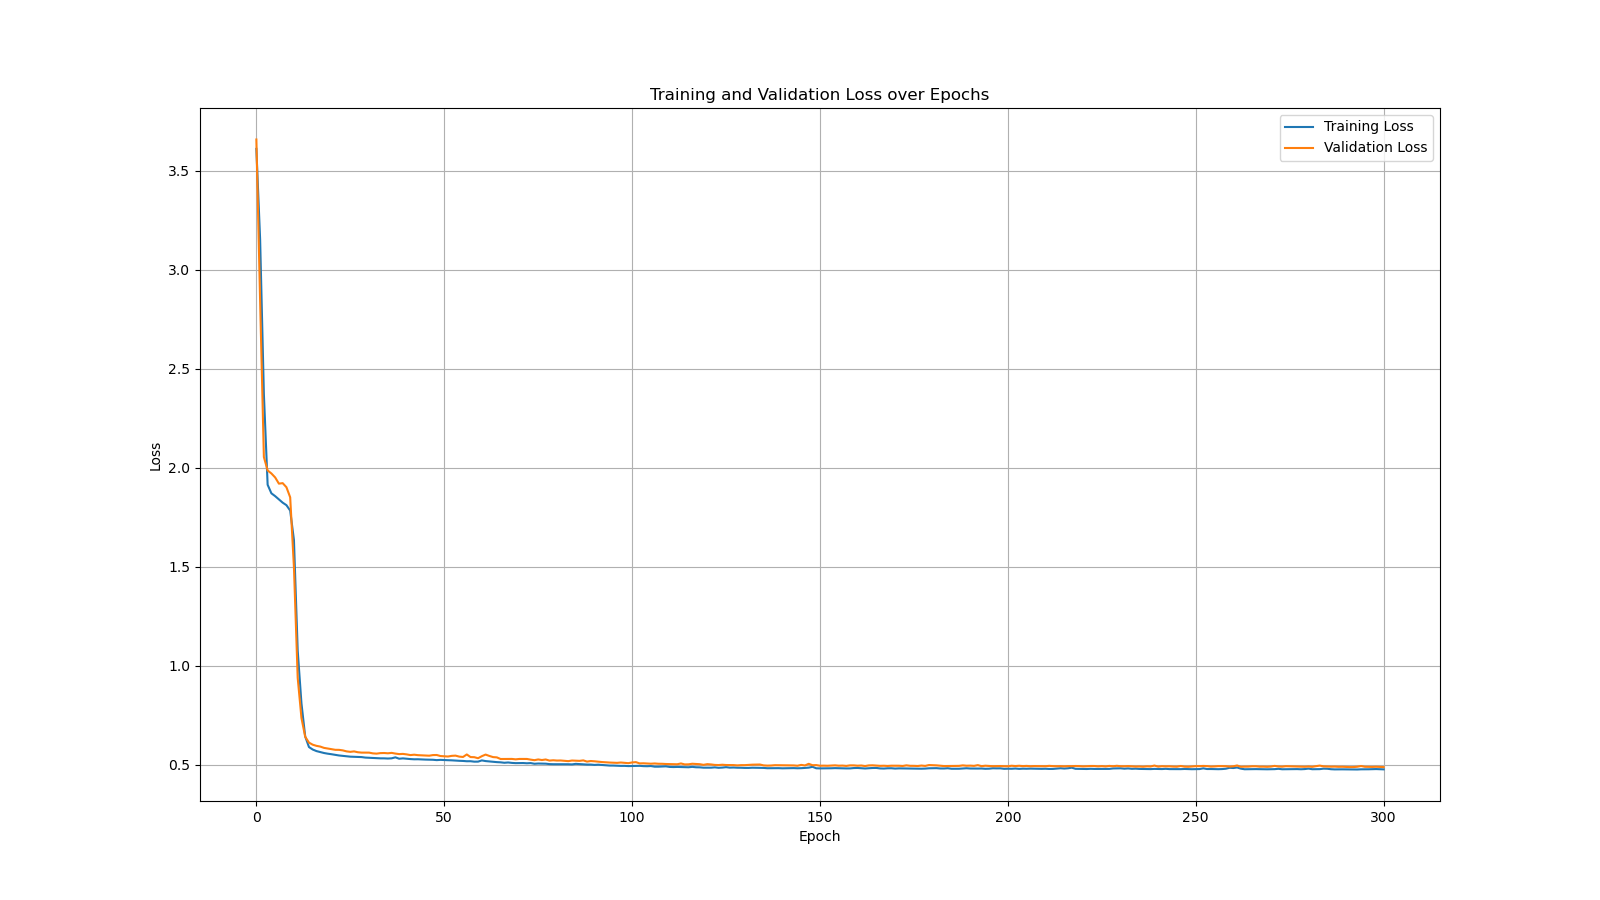

In [16]:
plt.figure(figsize=(16, 9))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.grid(True)
plt.show()


In [11]:
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for index, (q, M_q, A_q) in enumerate(train_dataloader):
        batch_size = batch[0].shape[0]
        q = q.to(device)
        q.requires_grad = True
        q_d = batch[0].to(device)

        M_q = M_q.to(device)
        A_q = A_q.to(device)
        
        theta, J_h, q_hat, J_h_ana = model(q)  
                
        M_th = transforms.transform_M(M_q, J_h, device)
        A_th = transforms.transform_input_matrix(A_q, J_h, device)

        
        loss_reconstruction = loss_terms.loss_reconstruction(q, q_hat)
        loss_diagonality_geo_mean = loss_terms.loss_diagonality_geo_mean(M_th, batch_size, device)
        #loss_diagonality_trace = loss_terms.loss_diagonality_trace(M_th, batch_size, device)
        #loss_diagonality_smallest = loss_terms.loss_diagonality_smallest(M_th, batch_size, device)
        ### Use J@J^T = eye to avoid needing to calculate the Jacobian inverse for efficiency. 
        loss_J_h_unitary = loss_terms.loss_J_h_unitary(J_h, batch_size, device)
        loss_J_h_cheat = loss_terms.loss_J_h_cheat(J_h, J_h_ana)
        loss_input_decoupling = loss_terms.loss_input_decoupling(A_th, batch_size, device, epoch)
        loss_h1_shaping = loss_terms.loss_h1_shaping(J_h, A_q, device)
        #loss_M_th_cheat = loss_terms.loss_M_th_cheat(M_th, rp, q, q_d, batch_size)
        #l1_norm = loss_terms.loss_l1(model)
        
        #loss_diagonality = 10 * loss_diagonality_geo_mean + loss_diagonality_smallest + 100 * loss_diagonality_trace
        loss_diagonality = loss_diagonality_geo_mean


        loss = 10 * loss_J_h_unitary + loss_input_decoupling + loss_diagonality + loss_reconstruction

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


NameError: name 'batch' is not defined

In [ ]:
# Extract epochs and losses
epochs = [entry[0] for entry in outputs]
losses = [entry[1].item() for entry in outputs]

# Plot loss as a function of epoch
plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='', label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()
